In [1]:
import calendar
import datetime as dt
import matplotlib.pyplot as plt
import numpy    as np
import os.path
import pandas   as pd
import random   as rand
import seaborn  as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# configuration
fulldata2015_filepath = '../../data/raw/wroclawski-rower-miejski/wypozyczenia_wrm-sezon2015.xlsx'
fulldata2016_filepath = '../../data/raw/wroclawski-rower-miejski/wypozyczenia_wrm-sezon2016.xlsx'

In [3]:
rentals2015_df_orig = pd.read_excel(fulldata2015_filepath)
rentals2016_df_orig = pd.read_excel(fulldata2016_filepath)

In [4]:
# A workaround to get fresh data and not to be forced to load the data file again (takes time!)
rentals2015_df = rentals2015_df_orig.copy()
rentals2016_df = rentals2016_df_orig.copy()

# Data cleaning

### Records with 0s of bike rental time length

In [5]:
print("Number of rentals (in 2015) with duration 0 seconds: {}".format(len(rentals2015_df[ rentals2015_df["Data zwrotu"] == rentals2015_df["Data wynajmu"] ])))
print("Number of rentals (in 2016) with duration 0 seconds: {}".format(len(rentals2016_df[ rentals2016_df["Data zwrotu"] == rentals2016_df["Data wynajmu"] ])))

# Rentals with duration 0 seconds are considered as incorrect, thus will be deleted
rentals2015_df.drop(rentals2015_df[ rentals2015_df["Data zwrotu"] == rentals2015_df["Data wynajmu"] ].index, inplace=True)
rentals2016_df.drop(rentals2016_df[ rentals2016_df["Data zwrotu"] == rentals2016_df["Data wynajmu"] ].index, inplace=True)

print("Data cleaning verification:")
print("Number of rentals (in 2015) with duration 0 seconds: {}".format(len(rentals2015_df[ rentals2015_df["Data zwrotu"] == rentals2015_df["Data wynajmu"] ])))
print("Number of rentals (in 2016) with duration 0 seconds: {}".format(len(rentals2016_df[ rentals2016_df["Data zwrotu"] == rentals2016_df["Data wynajmu"] ])))

Number of rentals (in 2015) with duration 0 seconds: 47
Number of rentals (in 2016) with duration 0 seconds: 176
Data cleaning verification:
Number of rentals (in 2015) with duration 0 seconds: 0
Number of rentals (in 2016) with duration 0 seconds: 0


### One-hour time shift at the end of Daylight Saving Time (DST)

The Daylight Saving Time change took place in Poland on:
* 2015-03-29 (2:00am => 3:00 am)
* 2015-10-25 (3:00am => 2:00 am)
* 2016-03-27 (2:00am => 3:00 am)
* 2016-10-30 (3:00am => 2:00 am)

#### Year 2015

##### 3:00am -> 2:00am

In [6]:
# bikes rented right before time shift from 3:00am  to 2:00am
idx = (rentals2015_df["Data wynajmu"] < '2015-10-25 03:00:00') & \
      (rentals2015_df["Data zwrotu"] < rentals2015_df["Data wynajmu"])
rentals2015_df.loc[idx, :]

,L.p.,Numer roweru,Data wynajmu,Data zwrotu,Stacja wynajmu,Stacja zwrotu
787264,787265,57490,2015-10-25 02:23:55,2015-10-25 02:21:33,Rynek,Dworzec Mikołajów
787266,787267,57257,2015-10-25 02:26:04,2015-10-25 02:21:47,Rynek,Dworzec Mikołajów
787281,787282,57167,2015-10-25 02:39:30,2015-10-25 02:12:04,Plac Grunwaldzki - Polaka,Świdnicka - Chrobry
787293,787294,57070,2015-10-25 02:59:10,2015-10-25 02:11:12,Plac Uniwersytecki,Sienkiewicza - Piastowska
787294,787295,57427,2015-10-25 02:59:43,2015-10-25 02:07:00,Arkady,Sky Tower


In [7]:
rentals2015_df.loc[idx, ["Data zwrotu"]] = rentals2015_df.loc[idx, ["Data zwrotu"]].apply(lambda x: x + dt.timedelta(hours=1))

print("Data cleaning verification:")
print("Number of falsy records: {}".format(len(rentals2015_df[ (rentals2015_df["Data wynajmu"] < '2015-10-25 03:00:00') & 
                                                               (rentals2015_df["Data zwrotu"] < rentals2015_df["Data wynajmu"]) ])))

Data cleaning verification:
Number of falsy records: 0


In [8]:
# another invalid records
print("Number of falsy records: {}".format(len(rentals2015_df[ rentals2015_df["Data zwrotu"] < rentals2015_df["Data wynajmu"] ])))

Number of falsy records: 0


#### Year 2016

##### 3:00am -> 2:00am

In [9]:
# bikes rented right before time shift from 3:00am  to 2:00am
idx = (rentals2016_df["Data wynajmu"] > '2016-10-30 00:00:00') & \
      (rentals2016_df["Data wynajmu"] < '2016-10-30 03:00:00') & \
      (rentals2016_df["Data zwrotu"] < rentals2016_df["Data wynajmu"])
rentals2016_df.loc[idx, :]

,L.p.,Numer roweru,Data wynajmu,Data zwrotu,Stacja wynajmu,Stacja zwrotu
979885,979886,57378,2016-10-30 02:59:58,2016-10-30 02:05:56,Dworzec Mikołajów,Dworzec Mikołajów
979887,979888,57666,2016-10-30 02:57:10,2016-10-30 02:07:34,Jedności Narodowej - Nowowiejska,Jedności Narodowej - Nowowiejska
979888,979889,57680,2016-10-30 02:56:29,2016-10-30 02:08:54,Jedności Narodowej - Nowowiejska,Jedności Narodowej - Nowowiejska
979889,979890,57783,2016-10-30 02:58:25,2016-10-30 02:14:12,Sienkiewicza - Wyszyńskiego,Sienkiewicza - Wyszyńskiego


In [10]:
rentals2016_df.loc[idx, ["Data zwrotu"]] = rentals2016_df.loc[idx, ["Data zwrotu"]].apply(lambda x: x + dt.timedelta(hours=1))

print("Data cleaning verification:")
print("Number of falsy records: {}".format(len(rentals2016_df.loc[  (rentals2016_df["Data wynajmu"] > '2016-10-30 00:00:00') & \
                                                                    (rentals2016_df["Data wynajmu"] < '2016-10-30 03:00:00') & \
                                                                    (rentals2016_df["Data zwrotu"] < rentals2016_df["Data wynajmu"])  ])))

Data cleaning verification:
Number of falsy records: 0


##### 2:00am -> 3:00am

In [11]:
# bikes rented right before time shift from 2:00am to 3:00am
idx = (rentals2016_df["Data wynajmu"] < '2016-03-27 02:00:00') & (rentals2016_df["Data zwrotu"] > '2016-03-27 03:00:00')
rentals2016_df.loc[idx, :]

,L.p.,Numer roweru,Data wynajmu,Data zwrotu,Stacja wynajmu,Stacja zwrotu
35640,35641,57075,2016-03-27 01:51:31,2016-03-27 03:01:13,Kredka i Ołówek,Kredka i Ołówek
35641,35642,57778,2016-03-27 01:51:21,2016-03-27 03:01:23,Żmigrodzka / Kasprowicza,Żmigrodzka / Kasprowicza
35642,35643,57580,2016-03-27 01:55:16,2016-03-27 03:06:22,Armii Krajowej - Borowska,Armii Krajowej - Borowska


In [12]:
rentals2016_df.loc[idx, ["Data zwrotu"]] = rentals2016_df.loc[idx, ["Data zwrotu"]].apply(lambda x: x + dt.timedelta(hours=-1))

In [13]:
print("Data cleaning verification:")
print("Number of falsy records: {}".format(len(rentals2016_df[ (rentals2016_df["Data wynajmu"] < '2016-03-27 02:00:00') & 
                                                               (rentals2016_df["Data zwrotu"] > '2016-03-27 03:00:00') ])))

Data cleaning verification:
Number of falsy records: 0


In [14]:
# another invalid records
rentals2016_df[ rentals2016_df["Data zwrotu"] <= rentals2016_df["Data wynajmu"] ]

,L.p.,Numer roweru,Data wynajmu,Data zwrotu,Stacja wynajmu,Stacja zwrotu
299038,299039,57222,2016-05-25 14:30:32,2016-05-25 14:30:30,Sky Tower,Sky Tower
725195,725196,57689,2016-08-16 11:00:37,2016-08-16 11:00:33,Powstańców Śląskich - Hallera,Powstańców Śląskich - Hallera
725576,725577,57213,2016-08-16 13:19:26,2016-08-16 13:19:24,Rynek,Rynek


In [15]:
# Rentals with negative duration time are considered as incorrect, thus will be deleted
rentals2016_df.drop(rentals2016_df[ rentals2016_df["Data zwrotu"] <= rentals2016_df["Data wynajmu"] ].index, inplace=True)

print("Data cleaning verification:")
print("Number of falsy records: {}".format(len(rentals2016_df[ rentals2016_df["Data zwrotu"] < rentals2016_df["Data wynajmu"] ])))

Data cleaning verification:
Number of falsy records: 0


## Rental stations

### 2015

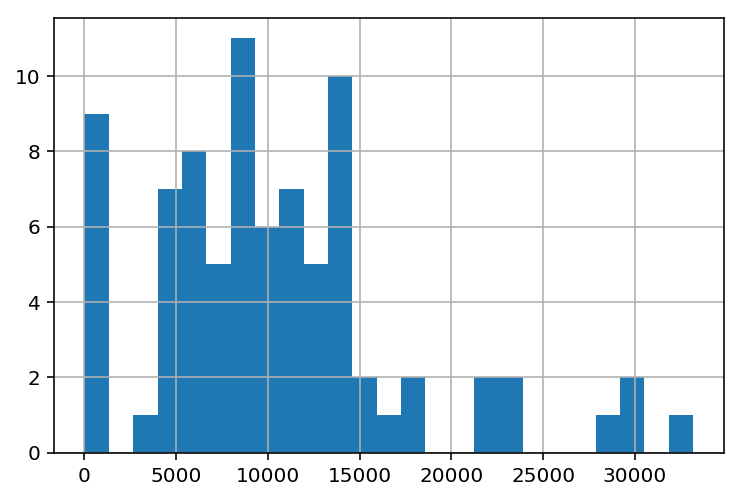

In [16]:
rentals2015_df.groupby(['Stacja wynajmu']).size().hist(bins=25);

In [17]:
rentals2015_df.groupby(['Stacja wynajmu']).size().sort_values(ascending=False).head(10)

Stacja wynajmu
Rynek                            33175
Wita Stwosza - Szewska           30211
Rondo Reagana                    29359
Sky Tower                        28253
Arkady                           22978
Świdnicka - Chrobry              22687
Plac Bema                        21623
Dworzec kolejowy - północ        21363
Powstańców Śląskich - Hallera    18259
Jana Pawła II                    17910
dtype: int64

In [18]:
rentals2015_df.groupby(['Stacja wynajmu']).size().sort_values(ascending=False).tail(15)

Stacja wynajmu
Bajana - Szybowcowa               4926
Grochowa - Jemiołowa              4798
Strzegomska - Gubińska            4692
Hallera - Odkrywców               4669
Promenady Business Park           4328
Mickiewicza - pętla tramwajowa    3952
Aleja Bielany                       17
Ogrody                               2
Dworzec Głowny PKP                   1
Pętla Autobusowa - Dambonia          1
Plac Wolnosci                        1
Most Teatralny                       1
Wiejska / Pogodna                    1
Grunwaldzka / Grochowska             1
Poznań Główny                        1
dtype: int64

In [19]:
df2015 = rentals2015_df.groupby(['Stacja wynajmu'])
df2015_size = df2015.size()
suspected_rentalstations_2015 = list(df2015_size[df2015_size < 10].index)

In [20]:
rentals2015_df[ rentals2015_df['Stacja wynajmu'].isin(suspected_rentalstations_2015) ]

,L.p.,Numer roweru,Data wynajmu,Data zwrotu,Stacja wynajmu,Stacja zwrotu
132014,132015,57481,2015-05-24 23:14:33,2015-05-24 23:37:43,Poznań Główny,Olszewskiego - Spółdzielcza
153397,153398,57010,2015-05-28 17:08:47,2015-05-28 17:23:24,Most Teatralny,Powstańców Śląskich - Hallera
283581,283582,57060,2015-06-19 16:50:54,2015-06-19 16:56:28,Grunwaldzka / Grochowska,Nowowiejska - Prusa
309026,309027,57438,2015-06-25 11:29:32,2015-06-25 11:30:20,Dworzec Głowny PKP,Plac Uniwersytecki
443140,443141,57574,2015-07-23 18:43:40,2015-07-23 18:52:49,Pętla Autobusowa - Dambonia,Świdnicka - Chrobry
534051,534052,57622,2015-08-13 06:45:40,2015-08-13 07:01:13,Ogrody,Powstańców Śląskich - Hallera
534861,534862,57107,2015-08-13 11:14:35,2015-08-13 11:41:35,Ogrody,Świdnicka - Chrobry
661439,661440,57196,2015-09-13 03:51:41,2015-09-13 04:04:14,Plac Wolnosci,Zachodnia - Poznańska
799041,799042,57607,2015-10-30 15:58:49,2015-10-30 16:06:35,Wiejska / Pogodna,Wiejska / Pogodna


Further analysis performed by googling:
* Poznań Główny - rental station in Poznań city
* Most Teatralny - rental station in Poznań city
* Grunwaldzka / Grochowska - rental station in Poznań city
* Dworzec Głowny PKP -> Plac Uniwersytecki - unknown city (inferred from the length of rental time)
* Pętla Autobusowa - Dambonia - rental station in Opole city
* Wiejska / Pogodna	- rental station in Białystok

### 2016

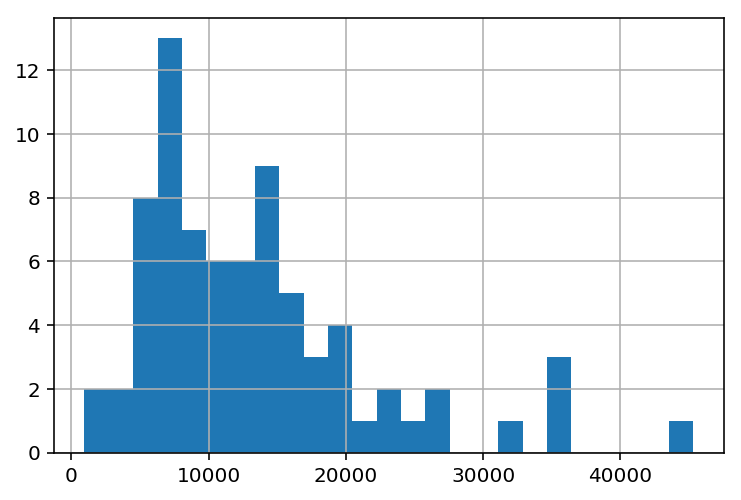

In [21]:
rentals2016_df.groupby(['Stacja wynajmu']).size().hist(bins=25);

In [22]:
rentals2016_df.groupby(['Stacja wynajmu']).size().sort_values(ascending=False).head(10)

Stacja wynajmu
Rynek                            45296
Świdnicka - Chrobry              35606
Rondo Reagana                    35309
Wita Stwosza - Szewska           34837
Sky Tower                        32306
Dworzec kolejowy - północ        26589
Arkady                           26281
Plac Bema                        24346
Hala Targowa                     23891
Powstańców Śląskich - Hallera    23667
dtype: int64

In [23]:
rentals2016_df.groupby(['Stacja wynajmu']).size().sort_values(ascending=False).tail(15)

Stacja wynajmu
Olszewskiego - Spółdzielcza       6676
Żeromskiego - Daszyńskiego        6670
Racławicka - Rymarska             6528
Bajana - Szybowcowa               6228
Zaporoska - Krucza                6050
Grochowa - Jemiołowa              5782
Krucza - Mielecka                 5687
Żeromskiego - Kluczborska         5559
Żelazna - Pereca                  5503
Strzegomska - Gubińska            5072
Mickiewicza - pętla tramwajowa    4718
Hallera - Odkrywców               4300
ul. Ruska                         3417
Aleja Bielany                     1092
Strachocińska / Wieśniacza         950
dtype: int64

## Return bike stations

### 2015

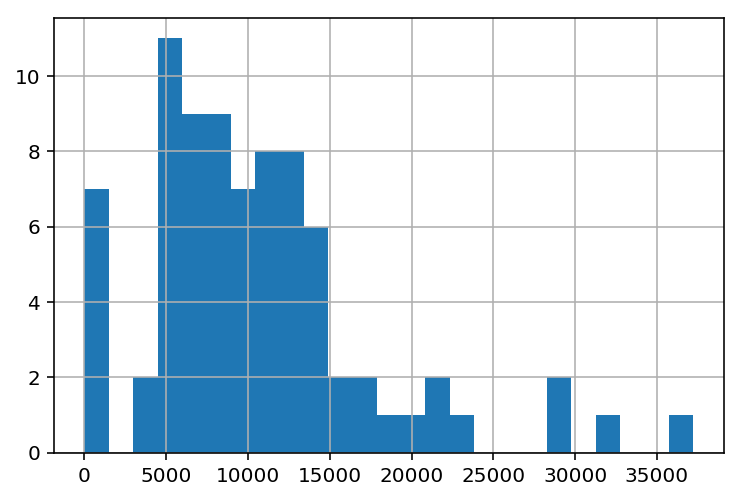

In [24]:
rentals2015_df.groupby(['Stacja zwrotu']).size().hist(bins=25);

In [25]:
rentals2015_df.groupby(['Stacja zwrotu']).size().sort_values(ascending=False).head(10)

Stacja zwrotu
Rynek                            37221
Wita Stwosza - Szewska           31462
Rondo Reagana                    29387
Sky Tower                        28313
Świdnicka - Chrobry              23105
Arkady                           22237
Plac Bema                        21536
Dworzec kolejowy - północ        20626
Powstańców Śląskich - Hallera    18474
Jana Pawła II                    16631
dtype: int64

In [26]:
rentals2015_df.groupby(['Stacja zwrotu']).size().sort_values(ascending=False).tail(10)

Stacja zwrotu
Hallera - Odkrywców               4636
Promenady Business Park           4171
Mickiewicza - pętla tramwajowa    4168
Aleja Bielany                       14
Grunwaldzka / Grochowska             1
Most Teatralny                       1
Dworzec Głowny PKP                   1
Plac Wolnosci                        1
Poznań Główny                        1
Wiejska / Pogodna                    1
dtype: int64

### 2016

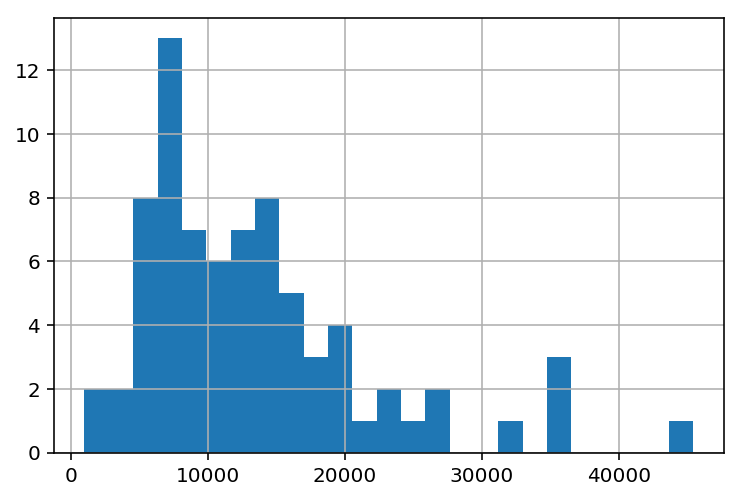

In [27]:
rentals2016_df.groupby(['Stacja zwrotu']).size().hist(bins=25);

In [28]:
rentals2016_df.groupby(['Stacja zwrotu']).size().sort_values(ascending=False).head(10)

Stacja zwrotu
Rynek                            45439
Świdnicka - Chrobry              35627
Rondo Reagana                    35317
Wita Stwosza - Szewska           34903
Sky Tower                        32314
Dworzec kolejowy - północ        26645
Arkady                           26210
Plac Bema                        24365
Hala Targowa                     23831
Powstańców Śląskich - Hallera    23632
dtype: int64

In [29]:
rentals2016_df.groupby(['Stacja zwrotu']).size().sort_values(ascending=False).tail(10)

Stacja zwrotu
Grochowa - Jemiołowa              5809
Krucza - Mielecka                 5696
Żelazna - Pereca                  5521
Żeromskiego - Kluczborska         5513
Strzegomska - Gubińska            5099
Mickiewicza - pętla tramwajowa    4740
Hallera - Odkrywców               4288
ul. Ruska                         3478
Aleja Bielany                     1084
Strachocińska / Wieśniacza         974
dtype: int64

# Data analysis

## Rental Seasons

In [30]:
def get_season_start_date_and_end_date(df):
    index_first = 0
    index_last  = df.index[-1]

    start_date = df.loc[index_first, "Data wynajmu"].date()
    end_date   = df.loc[index_last, "Data zwrotu"].date()
    return start_date, end_date

rentals2015_start_date, rentals2015_end_date = get_season_start_date_and_end_date(rentals2015_df)
print('Season 2015 started on: ', rentals2015_start_date)
print('Season 2015 ended on:   ', rentals2015_end_date)

rentals2016_start_date, rentals2016_end_date = get_season_start_date_and_end_date(rentals2016_df)
print('Season 2016 started on: ', rentals2016_start_date)
print('Season 2016 ended on:   ', rentals2016_end_date)

Season 2015 started on:  2015-04-28
Season 2015 ended on:    2015-11-30
Season 2016 started on:  2016-03-01
Season 2016 ended on:    2016-11-30


## Number of available bikes

In [31]:
unique_bikes_2015 = len(rentals2015_df["Numer roweru"].unique())
unique_bikes_2016 = len(rentals2016_df["Numer roweru"].unique())

unique_bikes_yoy_2015_2016 = (unique_bikes_2016-unique_bikes_2015)*100/unique_bikes_2015

print('Number of bikes in 2015: {}'.format(unique_bikes_2015))
print('Number of bikes in 2016: {} (change: {:.2f}% year-over-year)'.format(unique_bikes_2016, unique_bikes_yoy_2015_2016))

Number of bikes in 2015: 806
Number of bikes in 2016: 783 (change: -2.85% year-over-year)


**DATA INTERPRETATION**: This is interesting, the numer of bikes that were used in 2016 slightly decreased compared to 2015. City bikes are not popular in Wrocław? Luckily, this is not the downward trend, as the number of bikes increased up to 820 in [2018](https://wroclawskirower.pl/en/).

## Number of rentals

In [32]:
total_rentals_2015 = rentals2015_df.shape[0]
total_rentals_2016 = rentals2016_df.shape[0]

total_rentals_yoy_2015_2016 = (total_rentals_2016-total_rentals_2015)*100/total_rentals_2015

print('Number of all rentals in 2015: {}'.format(total_rentals_2015))
print('Number of all rentals in 2016: {} (change: {:.2f}% year-over-year)'.format(total_rentals_2016, total_rentals_yoy_2015_2016))

Number of all rentals in 2015: 843904
Number of all rentals in 2016: 1017192 (change: 20.53% year-over-year)


## Length of time of bike rental

### 2015

In [33]:
rentals2015_df["Długość wynajmu"] = rentals2015_df["Data zwrotu"] - rentals2015_df["Data wynajmu"]
rentals2015_df["Długość wynajmu"].describe()

count                    843904
mean     0 days 00:16:44.026968
std      0 days 00:44:33.303526
min             0 days 00:00:01
25%             0 days 00:06:38
50%             0 days 00:10:42
75%             0 days 00:15:44
max             5 days 17:26:32
Name: Długość wynajmu, dtype: object

In [34]:
rentals2016_df["Długość wynajmu"] = rentals2016_df["Data zwrotu"] - rentals2016_df["Data wynajmu"]
rentals2016_df["Długość wynajmu"].describe()

count                   1017192
mean     0 days 00:16:02.843418
std      0 days 00:36:38.278202
min             0 days 00:00:01
25%             0 days 00:06:42
50%             0 days 00:10:38
75%             0 days 00:15:30
max            13 days 05:09:11
Name: Długość wynajmu, dtype: object

In [35]:
total_rental_time_2015 = rentals2015_df["Długość wynajmu"].sum()
print("Total rental time in 2015: {}".format(total_rental_time_2015))

Total rental time in 2015: 9806 days 17:46:15


In [36]:
total_rental_time_2016 = rentals2016_df["Długość wynajmu"].sum()
total_rental_time_yoy_2015_2016 = (total_rental_time_2016.total_seconds()-total_rental_time_2015.total_seconds())*100/total_rental_time_2015.total_seconds()
print("Total rental time in 2016: {} (change: {:.2f}% year-over-year)".format(total_rental_time_2016, total_rental_time_yoy_2015_2016))

Total rental time in 2016: 11335 days 14:37:03 (change: 15.59% year-over-year)


In [37]:
def get_percentile_when_grace_period_reached(data):
    grace_period = 20*60         # first 20 minutes of rental time is free
    percentile = 1
    val = 0
    while val <= grace_period:
        if (percentile == 100):
            break;
        percentile += 1
        val = np.percentile(data, percentile, axis=0)
        #print('percentile: {}, value: {}'.format(percentile, val))
    return percentile-1

percentile_2015 = get_percentile_when_grace_period_reached(rentals2015_df["Długość wynajmu"].dt.total_seconds().values)
percentile_2016 = get_percentile_when_grace_period_reached(rentals2016_df["Długość wynajmu"].dt.total_seconds().values)
        
print("In 2015, {}% of users rented bike for max 20 minutes.".format(percentile_2015))
print("In 2016, {}% of users rented bike for max 20 minutes.".format(percentile_2016))

In 2015, 85% of users rented bike for max 20 minutes.
In 2016, 86% of users rented bike for max 20 minutes.


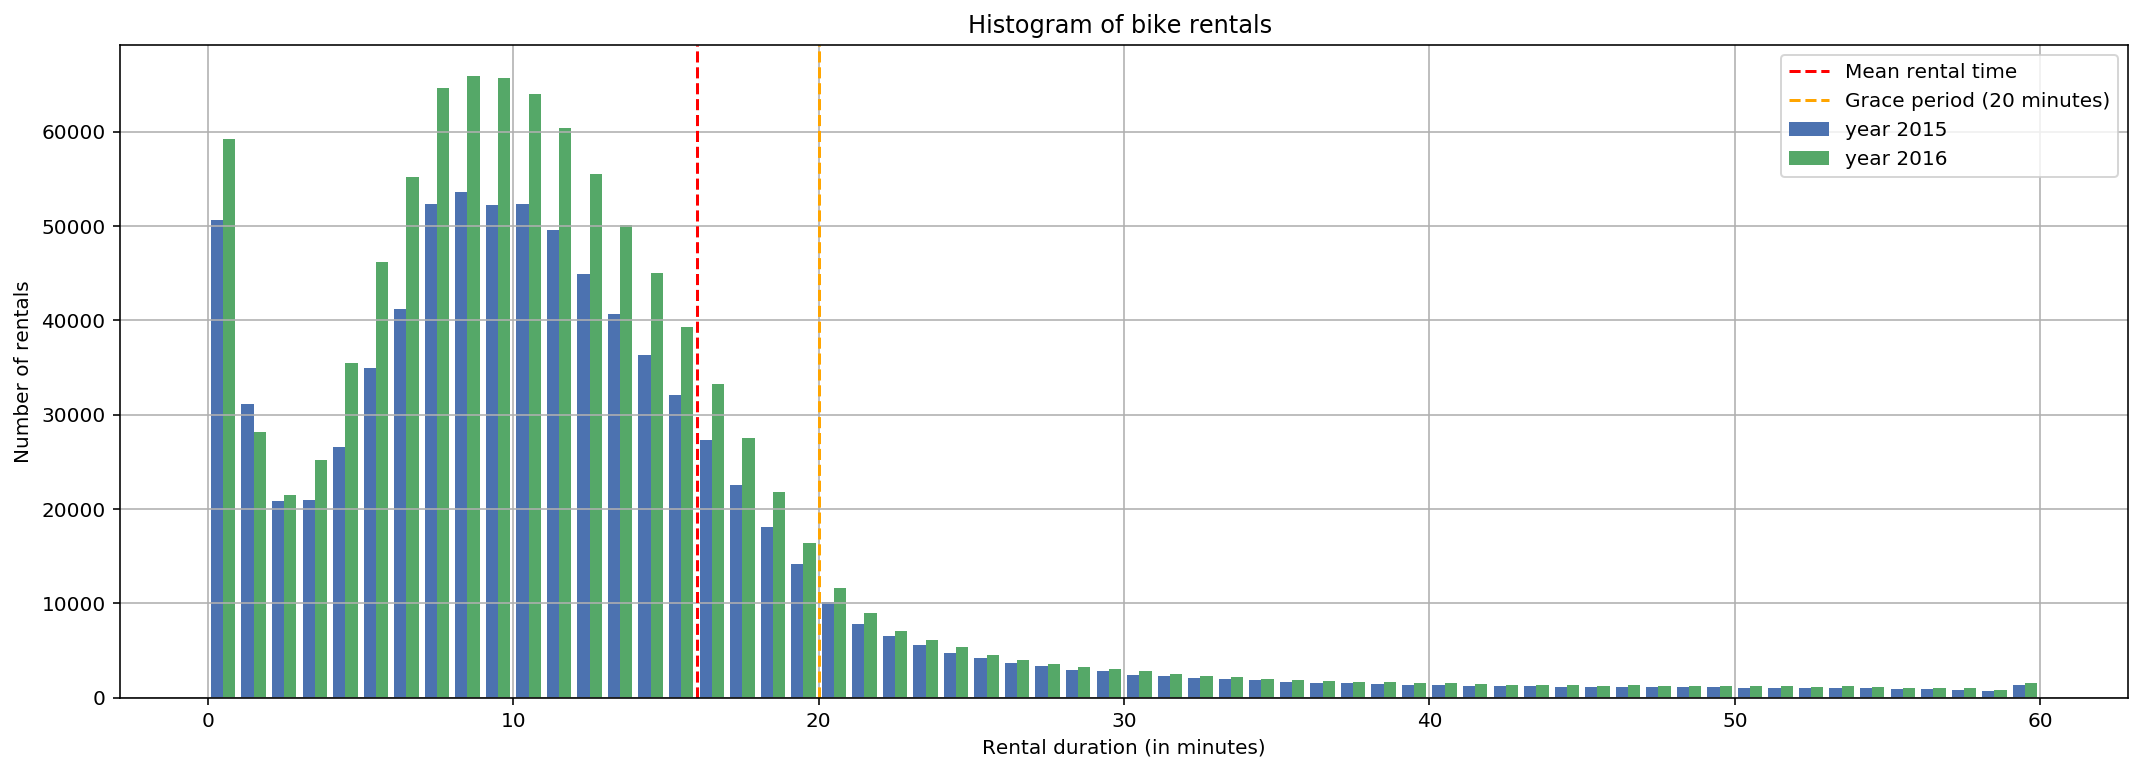

In [38]:
x_2015 = rentals2015_df["Długość wynajmu"].dt.total_seconds().values // 60 # in minutes
x_2016 = rentals2016_df["Długość wynajmu"].dt.total_seconds().values // 60 # in minutes

hours_threshold = 1
x_2015_trimmed = x_2015[ np.where(x_2015 <= hours_threshold*60) ] 
x_2016_trimmed = x_2016[ np.where(x_2016 <= hours_threshold*60) ]


plt.figure(figsize=(18,6))
plt.style.use('seaborn-deep')
plt.hist([x_2015_trimmed, x_2016_trimmed], 
         bins=hours_threshold*60, 
         label=['year 2015', 'year 2016']);
plt.axvline(rentals2016_df["Długość wynajmu"].describe()[1].total_seconds() // 60,
           linestyle='dashed',
           color='red',
           label='Mean rental time')

plt.axvline(20,
           linestyle='dashed',
           color='orange',
           label='Grace period (20 minutes)')

plt.title("Histogram of bike rentals ")
plt.xlabel("Rental duration (in minutes)")
plt.ylabel("Number of rentals")
plt.legend()
plt.grid(True)
plt.show()

**DATA INTERPRETATION**
* Average duration for bike rental is approx. 16 minutes, but usually people rent bikes for around 10.5 minutes.
* 85% of all rentals in 2015, and 86% in 2016 were free of charge (85% in 2015, 86% in 2016).

### Rentals made by early adopters

Assumption: Rentals with duration less that 1 minute as considered to be test rides made by early adopters.

In [39]:
test_rentals_2015_idx = rentals2015_df[ (rentals2015_df["Długość wynajmu"] < '00:01:00')]
print('Number of test rides in 2015: {} ({:.2f}% of all).'.format(len(test_rentals_2015_idx), len(test_rentals_2015_idx)*100 / total_rentals_2015))

test_rentals_2016_idx = rentals2016_df[ (rentals2016_df["Długość wynajmu"] < '00:01:00')]
print('Number of test rides in 2016: {} ({:.2f}% of all).'.format(len(test_rentals_2016_idx), len(test_rentals_2016_idx)*100 / total_rentals_2016))

Number of test rides in 2015: 50655 (6.00% of all).
Number of test rides in 2016: 59278 (5.83% of all).


### Bikes rental over time

In [40]:
# convert data into time series (time as index)
rentals2015_ts = pd.DataFrame(index = rentals2015_df["Data wynajmu"], 
                              columns = ["Count"], 
                              data=np.ones(rentals2015_df.shape[0]))
rentals2016_ts = pd.DataFrame(index = rentals2016_df["Data wynajmu"], 
                              columns = ["Count"], 
                              data=np.ones(rentals2016_df.shape[0]))

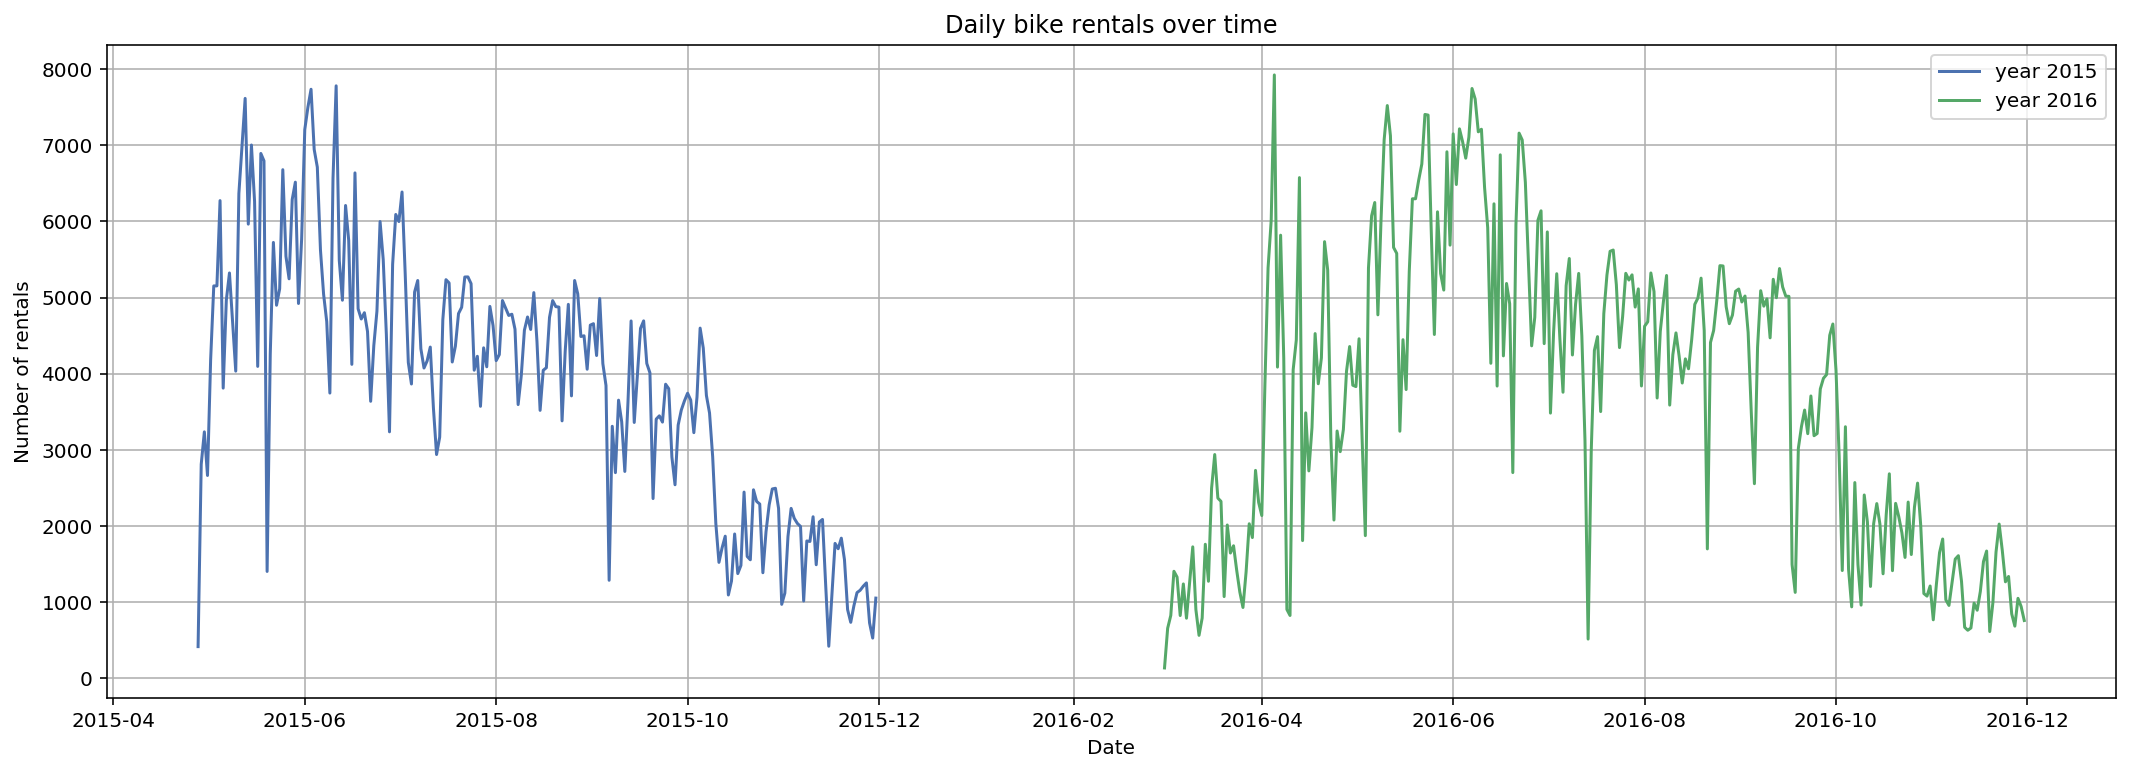

In [41]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(rentals2015_ts.resample("D").count(), label='year 2015');
ax.plot(rentals2016_ts.resample("D").count(), label='year 2016')

ax.set_title("Daily bike rentals over time")
ax.set_xlabel("Date")
ax.set_ylabel("Number of rentals");
ax.legend()
ax.grid(True)

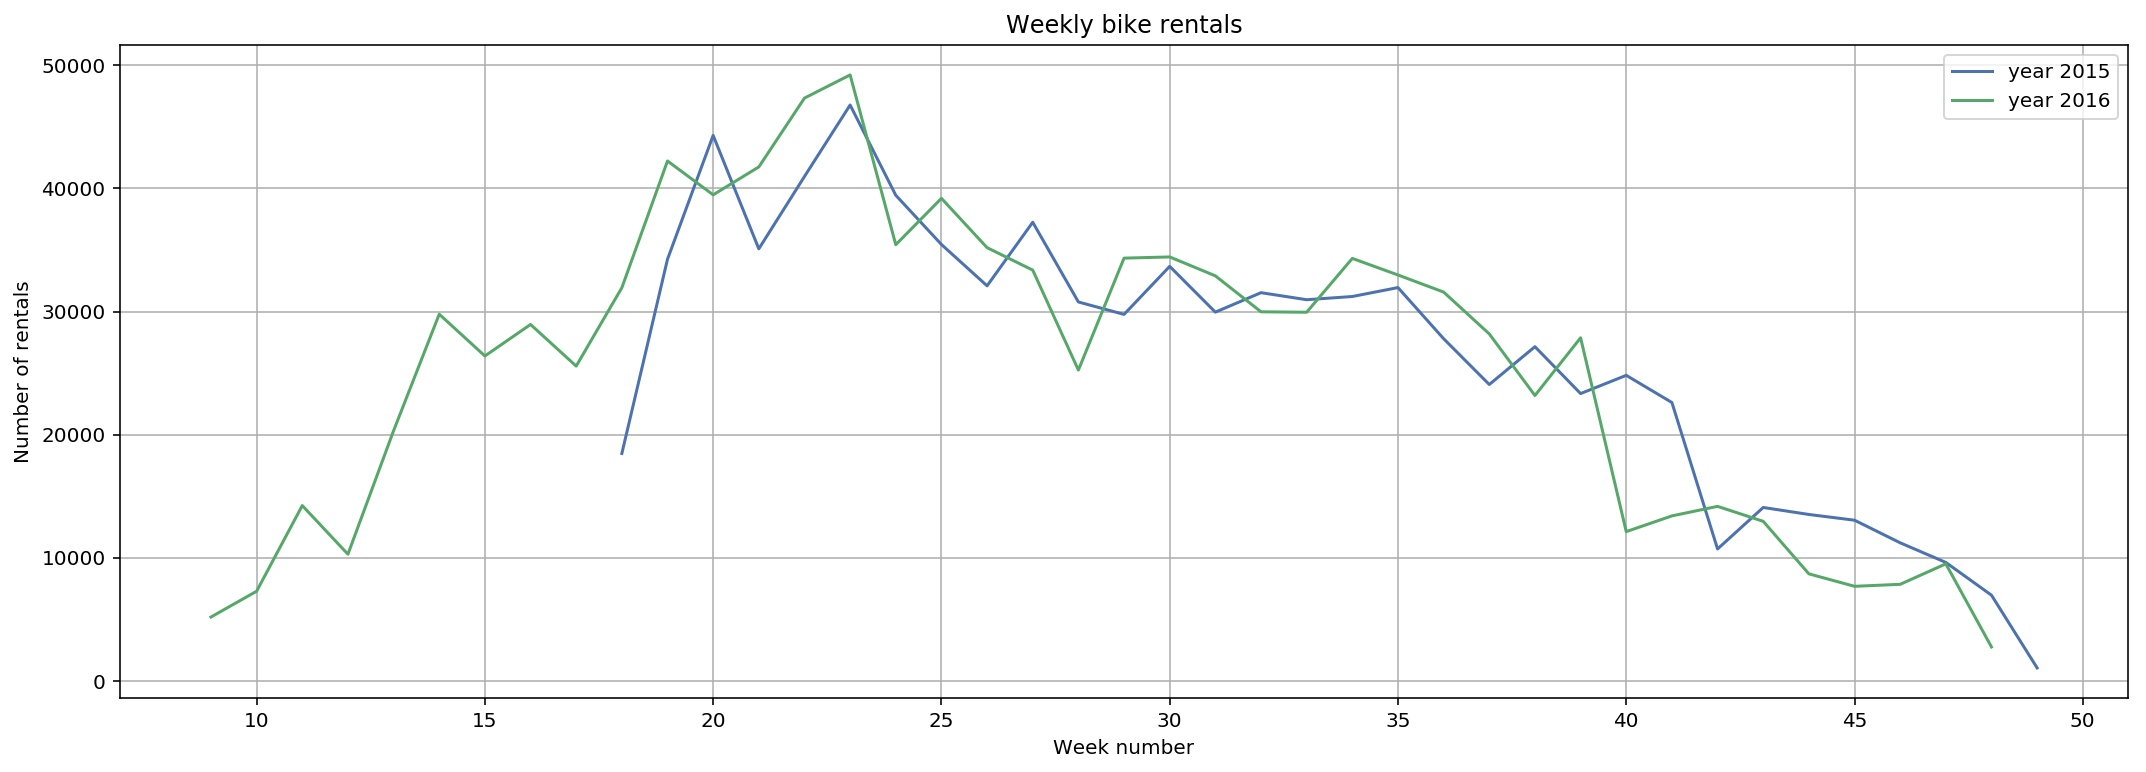

In [42]:
df2015 = rentals2015_ts.resample("W").count()
df2016 = rentals2016_ts.resample("W").count()

fig, ax = plt.subplots(figsize=(18,6))
ax.plot(df2015.index.week, df2015["Count"], label='year 2015');
ax.plot(df2016.index.week, df2016["Count"], label='year 2016')

ax.set_title("Weekly bike rentals")
ax.set_xlabel("Week number")
ax.set_ylabel("Number of rentals");
ax.legend()
ax.grid(True)

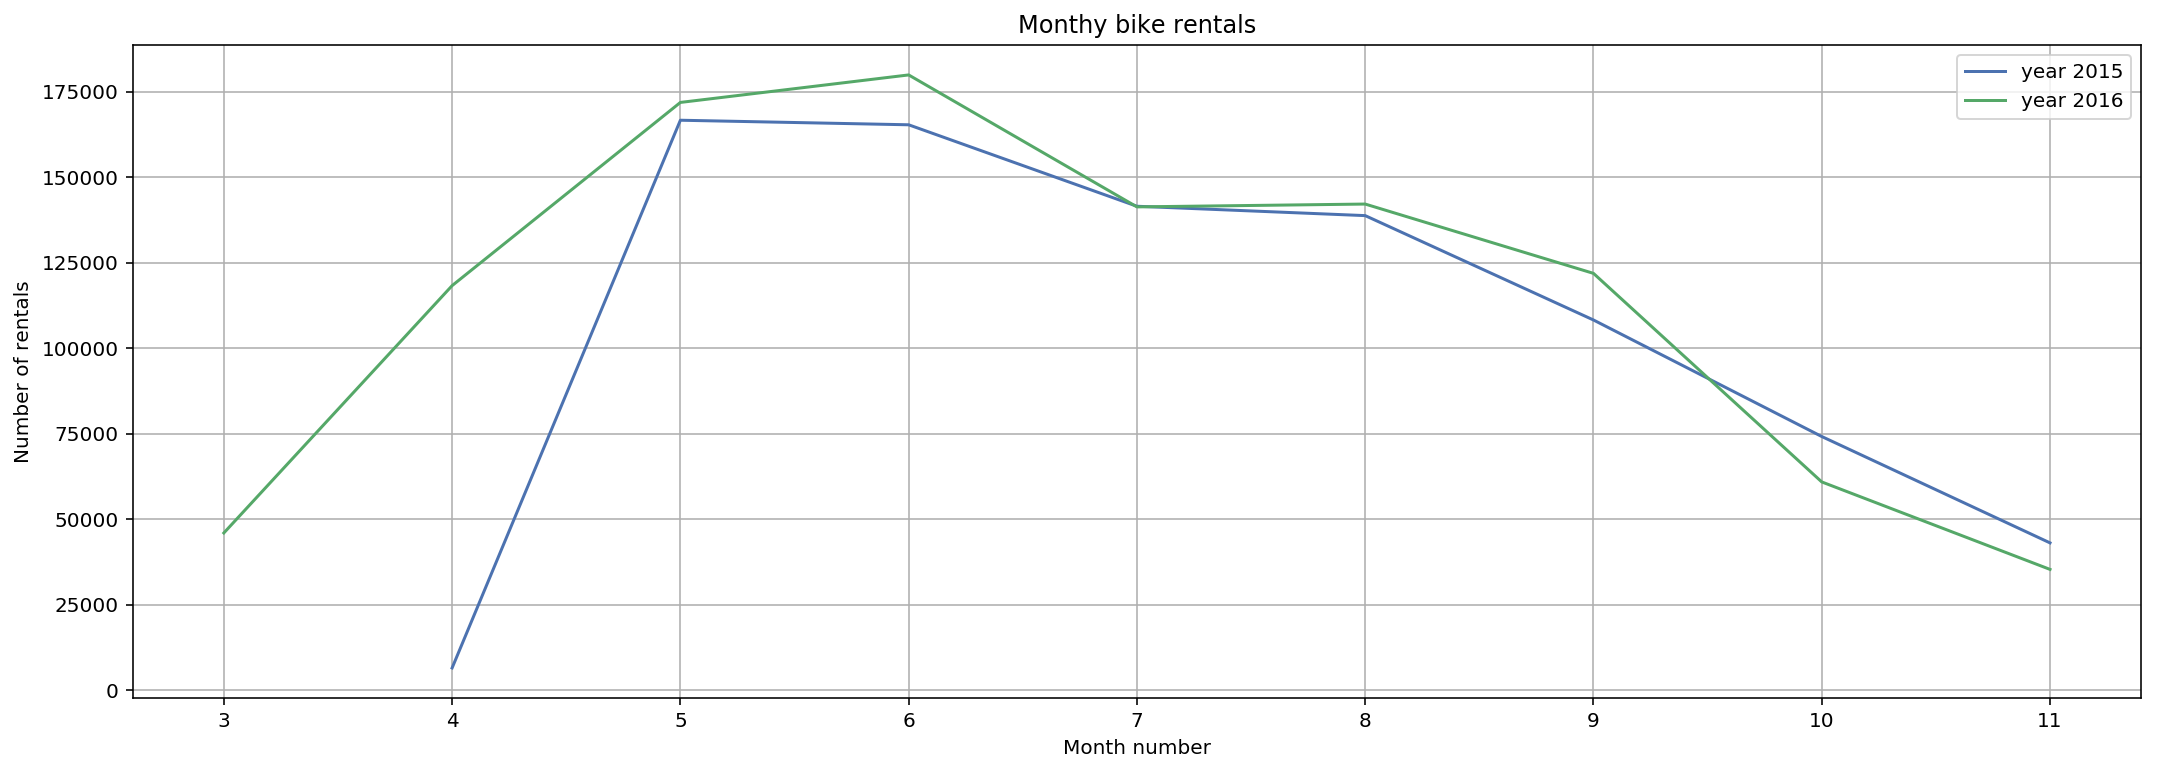

In [43]:
df2015 = rentals2015_ts.resample("M").count()
df2016 = rentals2016_ts.resample("M").count()

fig, ax = plt.subplots(figsize=(18,6))
ax.plot(df2015.index.month, df2015["Count"], label='year 2015');
ax.plot(df2016.index.month, df2016["Count"], label='year 2016')

ax.set_title("Monthy bike rentals")
ax.set_xlabel("Month number")
ax.set_ylabel("Number of rentals");
ax.legend()
ax.grid(True)

Year 2015, daily bike rentals, mean: 3888.96, std: 1686.38
Year 2016, daily bike rentals, mean: 3698.88, std: 1956.01


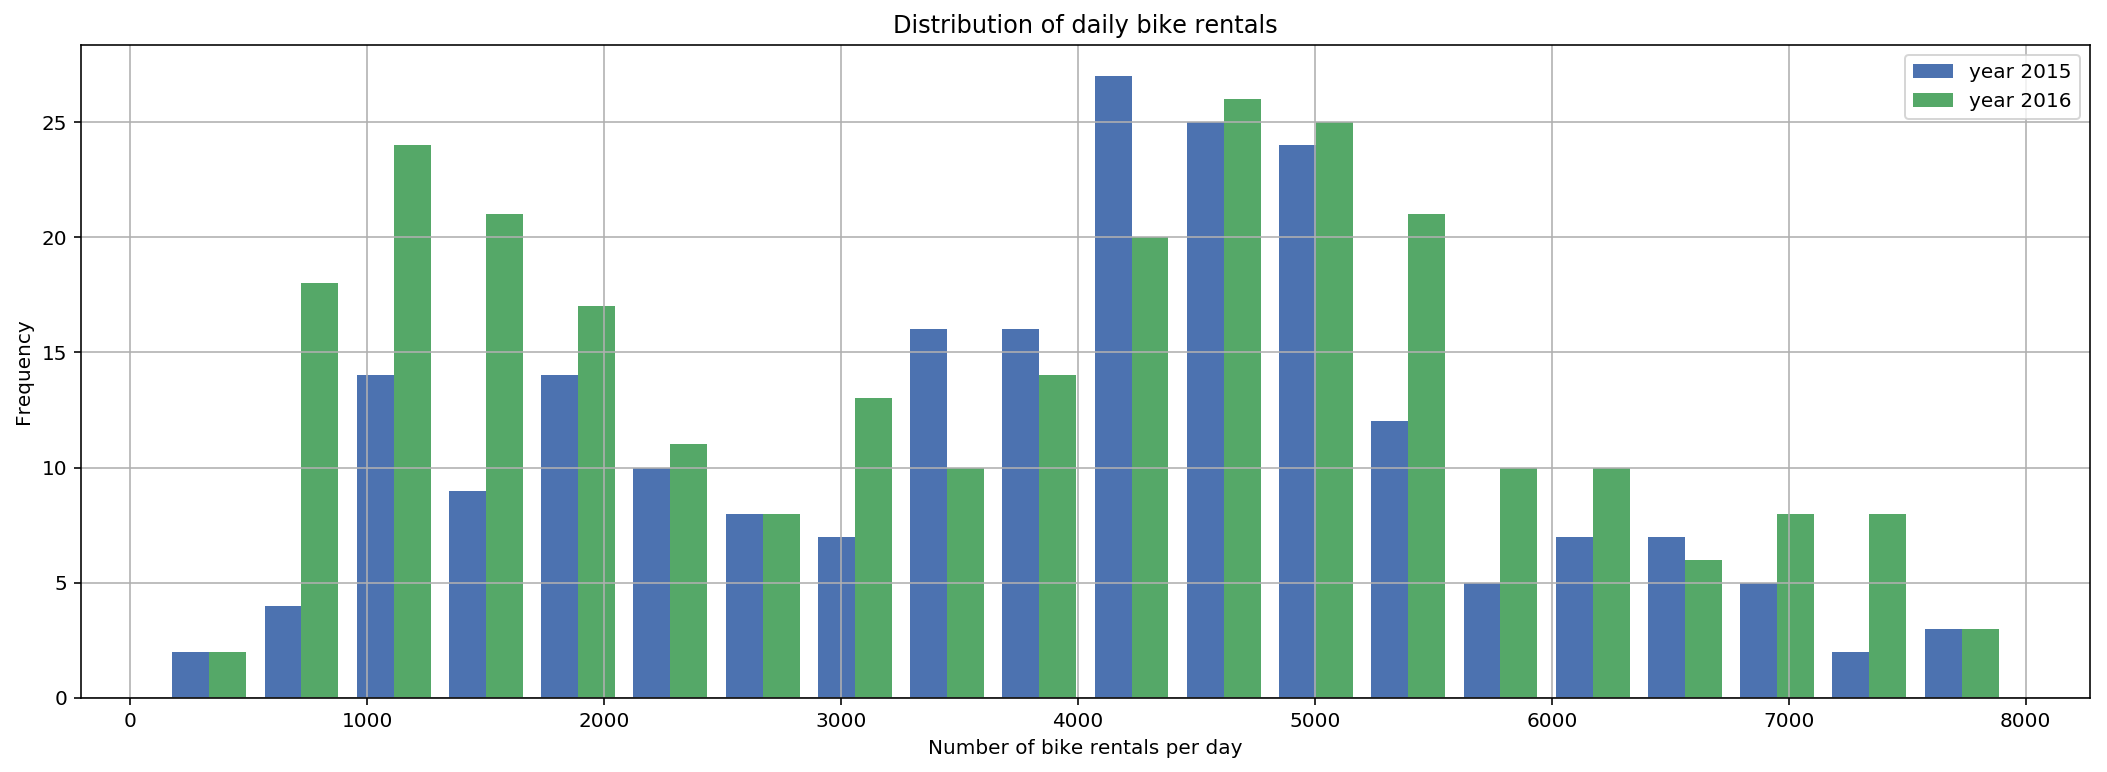

In [44]:
df2015 = rentals2015_ts.resample("D").count()["Count"].values
df2016 = rentals2016_ts.resample("D").count()["Count"].values

print("Year 2015, daily bike rentals, mean: {:.2f}, std: {:.2f}".format(df2015.mean(), df2015.std()))
print("Year 2016, daily bike rentals, mean: {:.2f}, std: {:.2f}".format(df2016.mean(), df2016.std()))

fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1, 1, 1)
ax.hist(x = [df2015, df2016], bins = 20, label=['year 2015', 'year 2016']);

ax.set_title("Distribution of daily bike rentals")
ax.set_xlabel("Number of bike rentals per day")
ax.set_ylabel("Frequency");
ax.legend()
ax.grid(True)

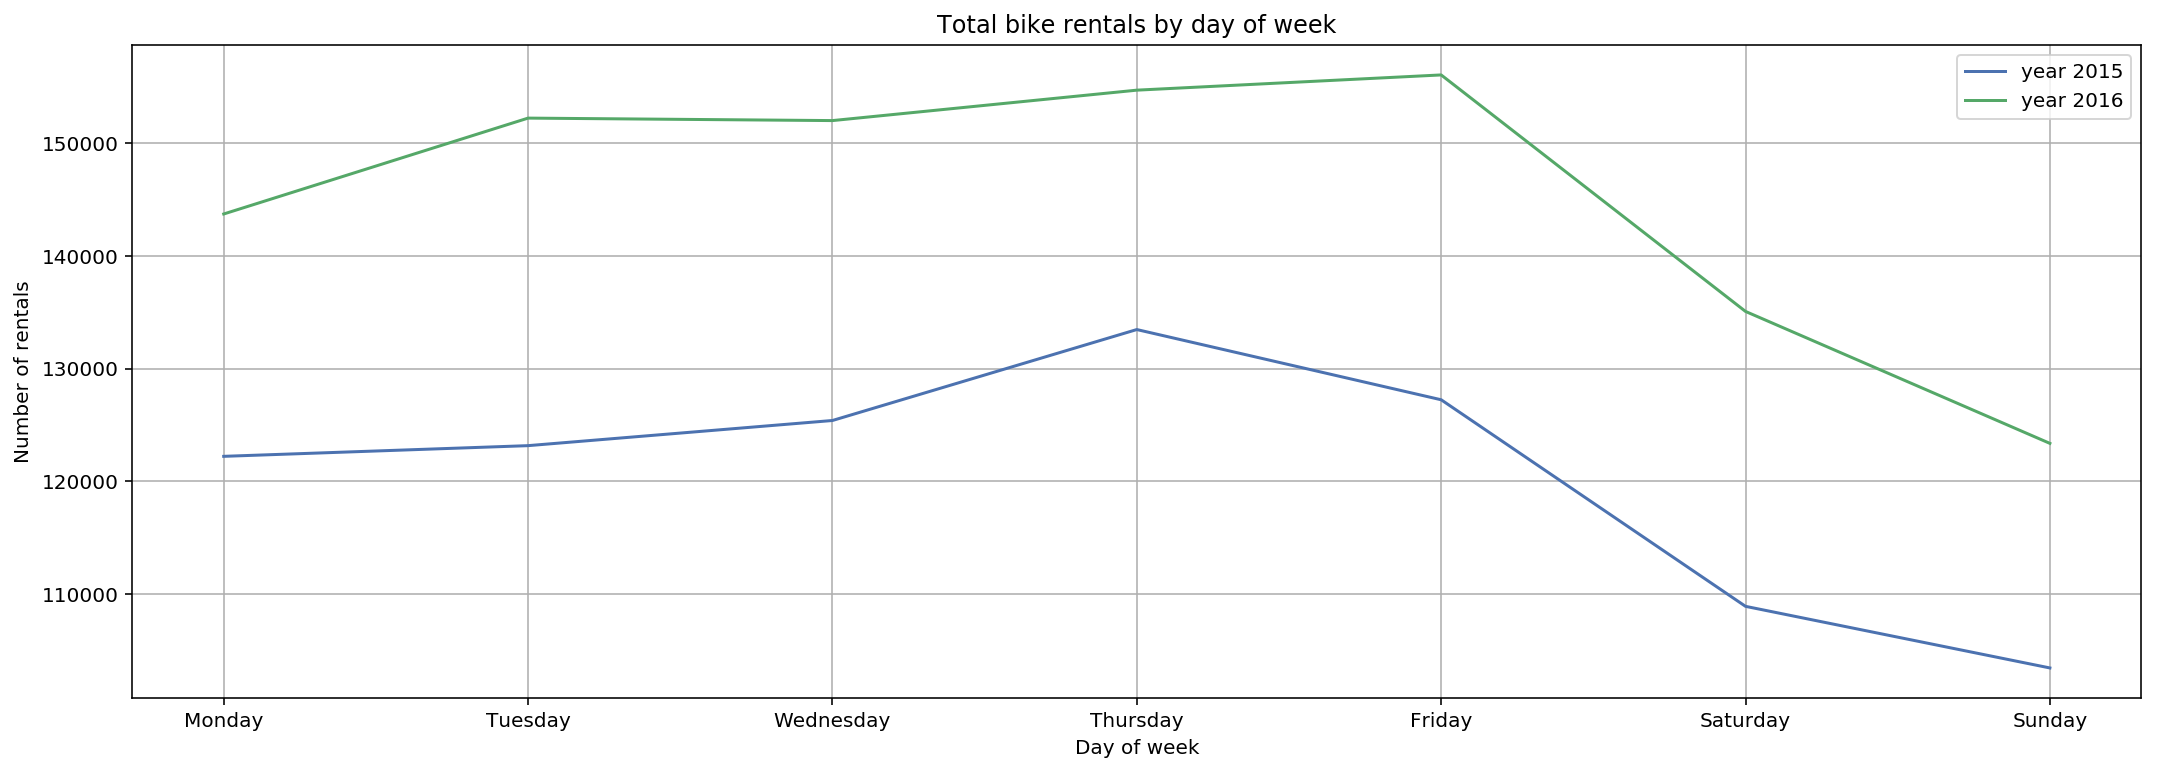

In [45]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(rentals2015_ts.groupby(rentals2015_ts.index.weekday)['Count'].sum(), label='year 2015');
ax.plot(rentals2016_ts.groupby(rentals2016_ts.index.weekday)['Count'].sum(), label='year 2016');

ax.set_title("Total bike rentals by day of week")
ax.set_xlabel("Day of week")
ax.set_ylabel("Number of rentals");
ax.set_xticklabels([''] + list(calendar.day_name))
ax.legend()
ax.grid(True)

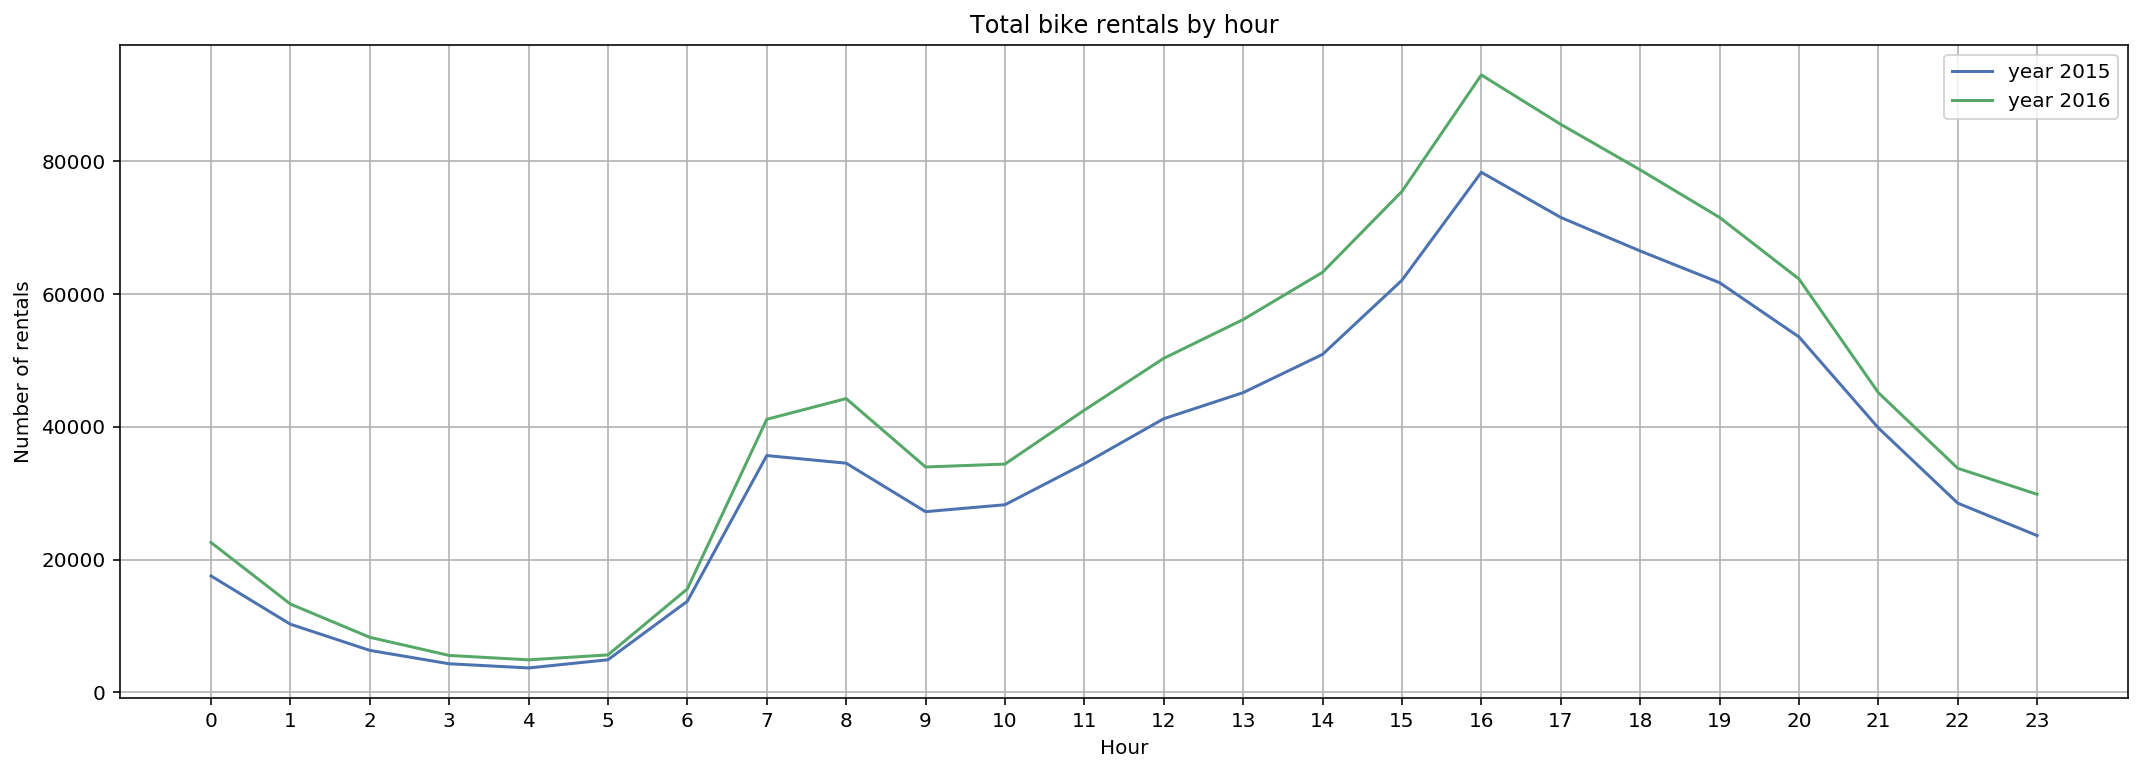

In [46]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(rentals2015_ts.groupby(rentals2015_ts.index.hour)['Count'].sum(), label='year 2015');
ax.plot(rentals2016_ts.groupby(rentals2016_ts.index.hour)['Count'].sum(), label='year 2016');

ax.set_title("Total bike rentals by hour")
ax.set_xlabel("Hour")
ax.set_ylabel("Number of rentals");
ax.set_xticks(np.arange(0, 24, 1))
ax.legend()
ax.grid(True)

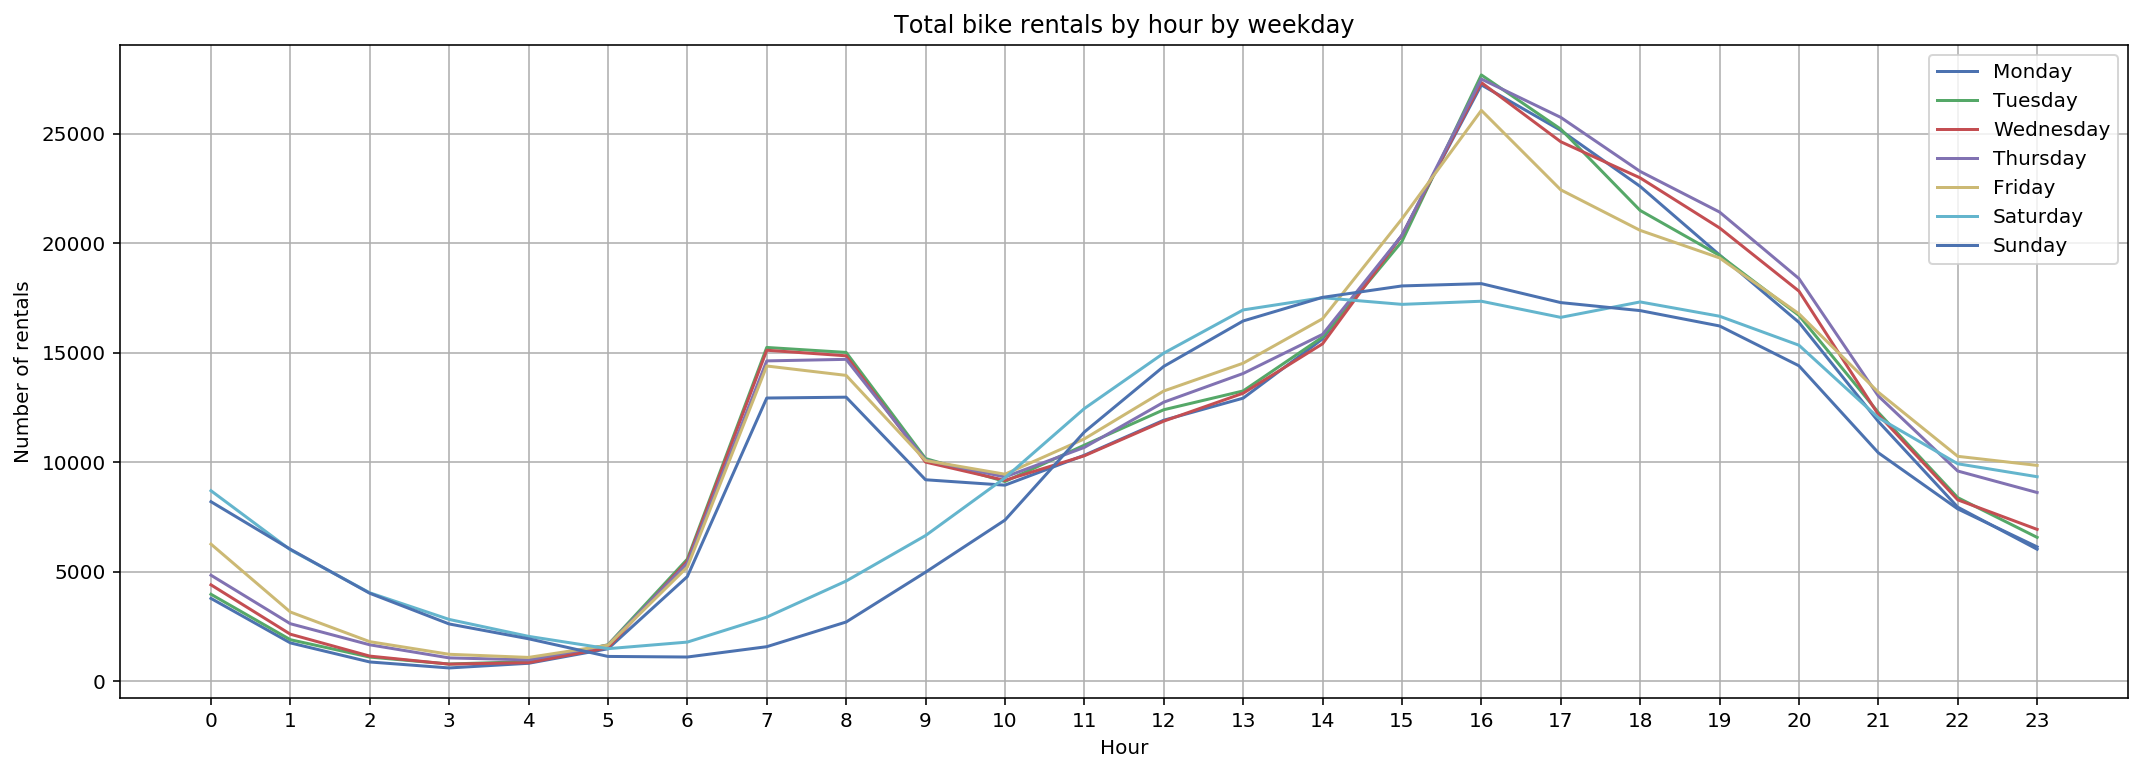

In [47]:
rentals = pd.concat([rentals2015_ts, rentals2016_ts])
rentals["Dzień wynajmu"] = rentals.index.dayofweek       # 0-Monday, 6-Sunday
rentals["Godzina wynajmu"] = rentals.index.hour          # separate column to have a nice index name in the pivot table

df = rentals.pivot_table(index=rentals["Godzina wynajmu"], 
                         columns='Dzień wynajmu', 
                         values='Count',                 # column to aggregate
                         aggfunc='sum')

fig, ax = plt.subplots(figsize=(18,6))
ax.plot(df);
ax.set_title("Total bike rentals by hour by weekday")
ax.set_xlabel("Hour")
ax.set_ylabel("Number of rentals");
ax.set_xticks(np.arange(0, 24, 1))
ax.legend(calendar.day_name)
ax.grid(True)

In [52]:
rentals2015_df.groupby(['Stacja wynajmu']).size().sort_values(ascending=False).reset_index(name='counts').head(10)

,Stacja wynajmu,counts
0,Rynek,33175
1,Wita Stwosza - Szewska,30211
2,Rondo Reagana,29359
3,Sky Tower,28253
4,Arkady,22978
5,Świdnicka - Chrobry,22687
6,Plac Bema,21623
7,Dworzec kolejowy - północ,21363
8,Powstańców Śląskich - Hallera,18259
9,Jana Pawła II,17910


In [50]:
rentals2015_df.groupby(['Stacja wynajmu']).size().sort_values(ascending=False)[-15:]

Stacja wynajmu
Bajana - Szybowcowa               4926
Grochowa - Jemiołowa              4798
Strzegomska - Gubińska            4692
Hallera - Odkrywców               4669
Promenady Business Park           4328
Mickiewicza - pętla tramwajowa    3952
Aleja Bielany                       17
Ogrody                               2
Dworzec Głowny PKP                   1
Pętla Autobusowa - Dambonia          1
Plac Wolnosci                        1
Most Teatralny                       1
Wiejska / Pogodna                    1
Grunwaldzka / Grochowska             1
Poznań Główny                        1
dtype: int64

In [51]:
# Extra:
# * nice example of plot analysis https://books.google.pl/books?id=8eZDDwAAQBAJ&pg=PA145&lpg=PA145&dq=ax.set_xticklabels+day+of+week&source=bl&ots=c6VZgG866Y&sig=-oEzqNcqPB1mjeKPtH_KywZMv84&hl=en&sa=X&ved=2ahUKEwj9-d28iqndAhWLlSwKHanpDPsQ6AEwBHoECAYQAQ#v=onepage&q=ax.set_xticklabels%20day%20of%20week&f=false

TODO:
- [x] number of rentals per day/week/month
- [x] number of rentals per day of week
- [x] total ~~average~~ bike rentals by day of week
- [x] number of rentals per hour
- [x] number of rentals per hour and day of week
- most popular bike stations for renting bikes
- most popular bike stations for returning bikes
- approx. overall distance travelled by bike
- estimated travel time from one bike station to another.

- DATA AUGMENTATION:
- holidays
- gps distance
- weather